### Imports 

In [1]:
from sagemaker.tensorflow import TensorFlow
from sagemaker.inputs import TrainingInput
from sagemaker import get_execution_role
import tensorflow as tf
import numpy as np
import sagemaker
import boto3
import os

In [2]:
print(f'Using TensorFlow version: {tf.__version__}')
print(f'Using SageMaker version: {sagemaker.__version__}')

Using TensorFlow version: 2.3.0
Using SageMaker version: 2.16.1


### Seed for Reproducability

In [3]:
SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)

### Essentials

In [4]:
role = get_execution_role()
session = boto3.Session()
sagemaker_session = sagemaker.Session()

s3 = session.resource('s3')
TF_FRAMEWORK_VERSION = '2.3.0'

BUCKET = 'cv-examples-892313895307' # USE YOUR ACCOUNT ID OR INITIALS AS SUFFIX
PREFIX = 'sign-language-clf'

### Create Train Script

In [42]:
%%file sign_language_train.py
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import vgg16
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import argparse
import os


# Set Log Level
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

SEED = 123
np.random.seed(SEED)
tf.random.set_seed(SEED)


def parse_args():
    parser = argparse.ArgumentParser() 
    # hyperparameters sent by the client are passed as command-line arguments to the script
    parser.add_argument('--epochs', type=int, default=1)
    parser.add_argument('--data', type=str, default=os.environ.get('SM_CHANNEL_DATA'))
    parser.add_argument('--output', type=str, default=os.environ.get('SM_CHANNEL_OUTPUT'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAIN'))
    parser.add_argument('--val', type=str, default=os.environ.get('SM_CHANNEL_VAL'))
    parser.add_argument('--model_dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    return parser.parse_known_args()


if __name__ == '__main__':
    print(f'Using TensorFlow version: {tf.__version__}')
    args, _ = parse_args()
    epochs = args.epochs
    device = '/cpu:0'
    with tf.device(device):
        # Load Data
        train_path = args.train
        validation_path = args.val
        train_batches = ImageDataGenerator().flow_from_directory(train_path, 
                                                                 target_size=(224, 224), 
                                                                 batch_size=10)
        validation_batches = ImageDataGenerator().flow_from_directory(validation_path,
                                                                      target_size=(224,224), 
                                                                      batch_size=30)
        # Load Base Model and Freeze Classification Layers
        base_model = vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (224,224, 3), pooling='avg')
        for layer in base_model.layers[:-5]:
            layer.trainable = False
        # Define a new Model
        last_layer = base_model.get_layer('global_average_pooling2d')
        last_output = last_layer.output
        x = Dense(10, activation='softmax', name='softmax')(last_output)
        new_model = Model(inputs=base_model.input, outputs=x)
        # Compile new Model
        new_model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
        new_model.fit(train_batches, 
                      steps_per_epoch=18, 
                      validation_data=validation_batches, 
                      validation_steps=3, 
                      epochs=epochs, 
                      verbose=1, 
                      callbacks=[])
        # Save Model
        new_model.save(f'{args.model_dir}/1')

Overwriting sign_language_train.py


### Load Local Data to S3

In [5]:
!rm -rf {train_path}/.ipynb_checkpoints
!rm -rf {validation_path}/.ipynb_checkpoints
!rm -rf {test_path}/.ipynb_checkpoints

In [ ]:
!aws s3 cp ./DATA/SIGN_LANGUAGE/ s3://{BUCKET}/{PREFIX}/ --recursive

In [13]:
train_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/train', 
                            distribution='ShardedByS3Key')
val_input = TrainingInput(s3_data=f's3://{BUCKET}/{PREFIX}/valid', 
                           distribution='ShardedByS3Key')

### Train Local Mode

In [14]:
hyperparameters = {'epochs': 1}
estimator = TensorFlow(entry_point='sign_language_train.py',
                       model_dir='/opt/ml/model/1/', # Note: this will a s3 path for real run
                       instance_type='local',
                       instance_count=1,
                       hyperparameters=hyperparameters,
                       role=role,
                       framework_version=TF_FRAMEWORK_VERSION, 
                       py_version='py37',
                       script_mode=True)

In [ ]:
estimator.fit({'train': 'file://./DATA/SIGN_LANGUAGE/train', 'val': 'file://./DATA/SIGN_LANGUAGE/valid'})

### Train Model on SageMaker

In [16]:
model_name = 'sign-lang-model-1'

hyperparameters = {'epochs': 20}
estimator_parameters = {'entry_point':'sign_language_train.py',
                        'instance_type': 'ml.m5.2xlarge',
                        'instance_count': 1,
                        'hyperparameters': hyperparameters,
                        'model_dir': f'/opt/ml/model',
                        'role': role,
                        'output_path': f's3://{BUCKET}/{PREFIX}/out',
                        'base_job_name': f'cv-{model_name}',
                        'framework_version': TF_FRAMEWORK_VERSION,
                        'py_version': 'py37',
                        'script_mode': True}

estimator = TensorFlow(**estimator_parameters)

In [ ]:
%%time

estimator.fit({'train': train_input, 'val': val_input})

In [18]:
model_location = estimator.model_data
model_location

's3://cv-examples-892313895307/sign-language-clf/out/cv-sign-lang-model-1-2020-11-27-16-30-08-932/output/model.tar.gz'

In [19]:
output_2 = f's3://{BUCKET}/{PREFIX}/mme/model-2.tar.gz'

In [20]:
!aws s3 cp {model_location} {output_2} 

copy: s3://cv-examples-892313895307/sign-language-clf/out/cv-sign-lang-model-1-2020-11-27-16-30-08-932/output/model.tar.gz to s3://cv-examples-892313895307/sign-language-clf/mme/model-2.tar.gz


### Deploy Model

In [21]:
from sagemaker.tensorflow import TensorFlowModel
from datetime import datetime
import time

In [22]:
current_time = datetime.fromtimestamp(time.time()).strftime('%Y-%m-%d-%H-%M-%S')
current_time

'2020-11-27-16-41-33'

In [23]:
model = TensorFlowModel(model_data=output_2, 
                        role=role,  
                        name=f'cv-sign-lang-model-{current_time}', 
                        sagemaker_session=sagemaker_session, 
                        framework_version=TF_FRAMEWORK_VERSION)

In [24]:
predictor = model.deploy(initial_instance_count=1, 
                         instance_type='ml.m5.xlarge', 
                         endpoint_name=f'cv-sign-lang-model-{current_time}')

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-----------!

### Real Time Inference - Test Deployed Endpoint 

In [29]:
%matplotlib inline
from tensorflow.keras.preprocessing import image
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt

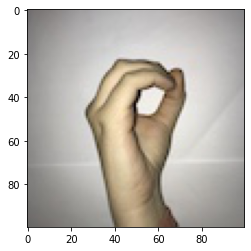

In [36]:
test_path  = './DATA/SIGN_LANGUAGE/test'
img = mpimg.imread(f'{test_path}/0/IMG_4159.JPG')
plt.imshow(img)

In [37]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

In [38]:
data = path_to_tensor(f'{test_path}/0/IMG_4159.JPG')
data.shape

(1, 224, 224, 3)

In [39]:
y_pred = predictor.predict(data)

In [40]:
predicted_label = np.argmax(y_pred)
print(f'Predicted Label: [{predicted_label}]')

Predicted Label: [0]
